In [36]:
import ipywidgets as widgets
from IPython.display import display
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helpers import spectrogram_plot_2024_func
from signal_api import butter_highpass_filter, butter_lowpass_filter
import glob
import os

with open('defaults.yaml', "r") as f:
    default_configs = yaml.safe_load(f)


# File chooser for CSV files
# Get all CSV files from ../data folder
csv_files = glob.glob(os.path.join('../data', '*.csv'))

file_chooser = widgets.Dropdown(
    options=csv_files,
    description='CSV File:',
    layout=widgets.Layout(width='50%')
)
data_folder_label = widgets.Label(value="Please select a CSV file from the '../data' folder.")

# LowPass and HighPass checkboxes
lowpass_checkbox = widgets.Checkbox(
    value=default_configs['LowPass']['enabled'],
    description='LowPass'
)
highpass_checkbox = widgets.Checkbox(
    value=default_configs['HighPass']['enabled'],
    description='HighPass'
)

# LowPass and HighPass numerical inputs
highpass_num = widgets.FloatText(
    value=default_configs['HighPass']['cutoff_frequency'],
    description='HighPass (Hz)'
)

lowpass_num = widgets.FloatText(
    value=default_configs['LowPass']['cutoff_frequency'],
    description='LowPass (Hz)'
)


# Window denoise tickbox
window_denoise_checkbox = widgets.Checkbox(
    value=default_configs['WindowDenoise']['enabled'],
    description='Window Denoise'
)
window_denoise_num = widgets.FloatText(
    value=default_configs['WindowDenoise']['threshold'],
    description='Threshold'
)

# PGA gain numerical inputs
pga_gain_label = widgets.Label(value="PGA Gain")
pga_gain_inputs = [
    widgets.FloatText(value=default_configs['PGA'][f'Ch{i+1}'], description=f'Ch{i+1}', layout=widgets.Layout(width='150px'))
    for i in range(5)
]
pga_gain_box = widgets.VBox([
    pga_gain_label,
    widgets.HBox(pga_gain_inputs, layout=widgets.Layout(width='100%'))
])

# Spectrogram frequency limit inputs
spec_lower_limit = widgets.FloatText(
    value=default_configs['SpectrogramLimits']['lower'],
    description='Lower(Hz)',
    layout=widgets.Layout(width='150px', description_width='300px')
)

spec_upper_limit = widgets.FloatText(
    value=default_configs['SpectrogramLimits']['upper'],
    description='Upper(Hz)',
    layout=widgets.Layout(width='150px', description_width='300px')
)

# Make frequency limit inputs flex in a horizontal box
verbose_checkbox = widgets.Checkbox(
    value=False,
    description='Verbose',
)

# Layout
ui = widgets.VBox([
    file_chooser,
    widgets.HBox([highpass_checkbox, highpass_num]),
    widgets.HBox([lowpass_checkbox, lowpass_num]),
    widgets.HBox([window_denoise_checkbox, window_denoise_num]),
    widgets.Label(value="Spectral Frequency Limit"),
    widgets.HBox([spec_lower_limit, spec_upper_limit]),
    widgets.Label(value="PGA Gain (Unused)"),
    widgets.HBox(pga_gain_inputs),
    verbose_checkbox,
])

display(ui)

In [37]:
from helpers import spectrogram_plot_2024_func, window_median_denoise, impute_with_left

fs = 80.0
data = pd.read_csv(file_chooser.value)

all_spectrograms = []
freq_lower_limit_idx = 0
freq_upper_limit_idx = 0

for col_idx in range(data.shape[1]):
    col_data = data.iloc[:, col_idx].to_numpy()
    col_data, nan_mask = impute_with_left(col_data)
    if verbose_checkbox.value:
        print(f"Column {col_idx}: {len(nan_mask)} NaNs were imputed with left values.")

    if highpass_checkbox.value:  
        col_data = butter_highpass_filter(col_data, highpass_num.value, int(fs))
    if lowpass_checkbox.value:
        col_data = butter_lowpass_filter(col_data, lowpass_num.value, int(fs))

    sepctrogram_data, freqs = spectrogram_plot_2024_func(col_data)
    if spec_lower_limit.value is not None:
        freq_lower_limit_idx = np.where(freqs >= spec_lower_limit.value)[0][0]
    if spec_upper_limit.value is not None:
        freq_upper_limit_idx = np.where(freqs <= spec_upper_limit.value)[0][-1]
    
    sepctrogram_data = sepctrogram_data[:, freq_lower_limit_idx:freq_upper_limit_idx + 1]   

    if window_denoise_checkbox.value:
        sepctrogram_data, denoise_mask = window_median_denoise(sepctrogram_data, window_denoise_num.value)
        if verbose_checkbox.value:
            print(f"Column {col_idx}: {len(denoise_mask)} windows were denoised.")

    all_spectrograms.append(sepctrogram_data)

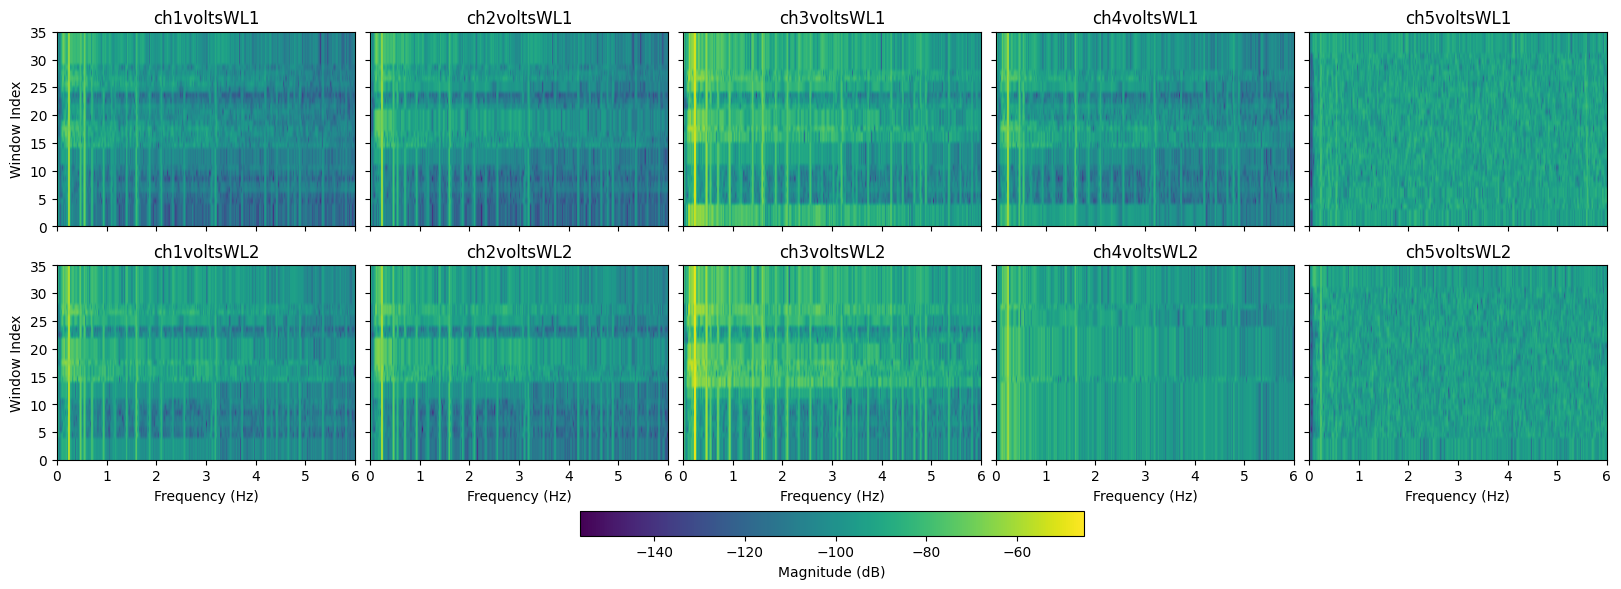

In [52]:
from matplotlib.image import AxesImage


combined_spectrogram = np.concatenate(all_spectrograms, axis=0)
v_max, v_min = np.max(np.abs(combined_spectrogram)), np.min(np.abs(combined_spectrogram))

fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharex=True, sharey=True)
im = None
for i, ax in enumerate(axes.flat):
    if i < 10 and i < len(all_spectrograms):
        spec = 20 * np.log10(np.abs(all_spectrograms[i]))
        extent = (freqs[freq_lower_limit_idx], freqs[freq_upper_limit_idx], 0, all_spectrograms[i].shape[0])
        im = ax.imshow(spec, aspect='auto', origin='lower', extent=extent, cmap='viridis', vmin=20*np.log10(v_min), vmax=20*np.log10(v_max))
        ax.set_title(data.columns[i])
        if i % 5 == 0:
            ax.set_ylabel('Window Index')
        if i >= 5:
            ax.set_xlabel('Frequency (Hz)')
fig.subplots_adjust(wspace=0.05)
# Place colorbar at the bottom horizontally
if isinstance(im, AxesImage):
    fig.subplots_adjust(bottom=0.25)
    fig.colorbar(im, ax=axes.ravel().tolist(), label='Magnitude (dB)', orientation='horizontal', fraction=0.05, pad=0.1)
